# Main goal: 
- Hani is looking for the final list of genes which are drug induced significantly methylated, expressed and stabilized. 

    ○ Venn diagram 

    ○ UpsetR 

=> table of these genes with all logFCs, pvalues and screening scores. 


In [1]:
# cp -v radar/result.all.txt hl60_delta_mtyl_table.txt

In [2]:
import pandas as pd 
import numpy as np
# Teated vs. non-treated 
comparisons = [
    # HL-60 meRIP-seq - logFC
    'meRIP-seq/hl60_delta_mtyl_table.txt' ,
    # HL-60 Ribo-seq - lnTE
    'Ribo-seq/hl60_delta_te_table.txt' ,
    # HL-60 RNA-seq 
    # RNA experssion - log2FC
    'RNA-seq/hl60-exp/hl60_delta_exp_table.txt',
    # RNA stability  - logFC
    'RNA-seq/hl60-stbl/hl60_delta_stbl_table.txt',
    ## 5 other AML cell lines RNA-seq
    # RNA experssion - log2FC
    'RNA-seq/other-exp/kg1_delta_exp_table.txt', 'RNA-seq/other-exp/molm14_delta_exp_table.txt',
    'RNA-seq/other-exp/ociaml2_delta_exp_table.txt', 'RNA-seq/other-exp/ociaml3_delta_exp_table.txt',
    'RNA-seq/other-exp/thp1_delta_exp_table.txt',
    # RNA stability - logFC
    'RNA-seq/other-stbl/kg1_delta_stbl_table.txt', 'RNA-seq/other-stbl/molm14_delta_stbl_table.txt',
    'RNA-seq/other-stbl/ociaml2_delta_stbl_table.txt', 'RNA-seq/other-stbl/ociaml3_delta_stbl_table.txt',
    'RNA-seq/other-stbl/thp1_delta_stbl_table.txt'
]


# extract cell line name experiment name 
names = [c.split('/')[-1].replace('.txt','').replace('_table','') for c in comparisons]
tables = [pd.read_csv(x, sep = '\t') for x in comparisons]
cells = [names[i].split('_')[0] for i,x in enumerate(comparisons)]
experiments = [names[i].replace(cells[i]+'_', '') for i,x in enumerate(comparisons)]

# read data into Pandas Data.Frames 
Data = dict(((c,{}) for c in cells))
for i,x in enumerate(comparisons): 
    cel = cells[i]
    exp = experiments[i]
    # read data and write into dictionary 
    Data [cel][exp] = tables[i]
    
# include CRISPR screening scores 
Data['hl60']['rho'] = pd.read_csv('screen/CRISPRi_HL60_rho.txt', header=None, sep = '\t').dropna().set_index(0)
Data['hl60']['gamma'] = pd.read_csv('screen/CRISPRi_HL60_gamma.txt', header=None, sep = '\t').dropna().set_index(0)

# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

In [3]:
Top = {}

## Translational efficiency

In [4]:
TE = Data['hl60']['delta_te'][['gene_id','gene_name','Estimate_treatmentDRUG','fdr_Pr...z.._treatmentDRUG']]

te_thr=1 # Estimate_treatmentDRUG
fdr_thr=0.50 # fdr_Pr...z.._treatmentDRUG

Top['TE'] = TE.iloc[
    [i for i,l in enumerate(
        np.array([
            np.array(TE.iloc[:,2].abs() >= te_thr),
            np.array(TE.iloc[:,3] < fdr_thr)]).all(axis=0)) if l == 1]
        ,:] 

Top['TE'].shape

(55, 4)

## $\Delta$RNA methylation

In [5]:
Mtyl = Data['hl60']['delta_mtyl'][['ensembl','name','logFC','p_value']]
Mtyl.columns = ['gene_id','gene_name','logFC','pval']

fc_thr = 4
pv_thr = 0.0001

Top['Hyper_m6A'] = Mtyl.iloc[
    [i for i,l in enumerate(
        np.array([
            np.array(Mtyl.iloc[:,2] >= fc_thr),
            np.array(Mtyl.iloc[:,3] < pv_thr)]).all(axis=0)) if l == 1]
        ,:].sort_values('pval').drop_duplicates(subset='gene_id', keep="last")


Top['Hypo_m6A'] = Mtyl.iloc[
    [i for i,l in enumerate(
        np.array([
            np.array(Mtyl.iloc[:,2] <= -fc_thr),
            np.array(Mtyl.iloc[:,3] < pv_thr)]).all(axis=0)) if l == 1]
        ,:].sort_values('pval').drop_duplicates(subset='gene_id', keep="last")

print (Top['Hyper_m6A'].shape, Top['Hypo_m6A'].shape)

(449, 4) (49, 4)


___

Function!

In [6]:
# it works for both below stablity and experssion data frames 
def find_top(
    df, n_line, 
    pv_thr=0.05, fc_thr=2,
    fc = range(1,13,2),
    pv  = range(2,13,2)):
    
    # Select rows (genes) which has abs(log2FC) >= fc_thr & pval < pv_thr 
    # in more than n_line cell lines 

    top = df.iloc[
        [i for i,l in enumerate(
            np.array([
                np.array(df.iloc[:,fc].abs() >= fc_thr).sum(axis=1) >= n_line,
                np.array(df.iloc[:,pv] < pv_thr).sum(axis=1) >= n_line
            ]).all(axis=0).tolist()) if l == 1
        ],:]
    
    return top

## $\Delta$RNA expression 

In [7]:
E1 = Data['hl60']['delta_exp']
E2 = Data['kg1']['delta_exp']
E3 = Data['molm14']['delta_exp']
E4 = Data['ociaml2']['delta_exp']
E5 = Data['ociaml3']['delta_exp']
E6 = Data['thp1']['delta_exp']

load R

In [8]:
%load_ext rpy2.ipython

In [15]:
%%R 
library (tidyverse)
library (UpSetR)

In [10]:
%%R -i E1,E2,E3,E4,E5,E6 -o exp_df

exp_ids = E1[,'gene_id']
exp_names = E1[,'gene_name']

Exp = list(
    # hl60
    E1 %>% dplyr::select('gene_id','log2FC_120h','pval_120h') %>% 
            rename(hl60.log2FC=log2FC_120h,
                   hl60.pval=pval_120h), 
    # kg1
    E2 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(kg1.log2FC=log2FoldChange,
                   kg1.pval=pvalue),  
    # molm14
    E3 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(molm14.log2FC=log2FoldChange,
                   molm14.pval=pvalue), 
    # ociaml2
    E4 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(ociaml2.log2FC=log2FoldChange,
                   ociaml2.pval=pvalue), 
    # ociaml3    
    E5 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>% 
            rename(ociaml3.log2FC=log2FoldChange,
                   ociaml3.pval=pvalue), 
    # thp1
    E6 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(thp1.log2FC=log2FoldChange,
                   thp1.pval=pvalue) 
)

for (i in 1:6){
    Exp[[i]] = Exp[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('gene_id')
    Exp[[i]] = Exp[[i]][exp_ids,]
    
}

exp_df <- bind_cols(Exp) %>% add_column(gene_name=exp_names, .before=1)

In [11]:
Top['Exp'] = find_top(exp_df, n_line=3, fc_thr=1)

Top['Exp'].shape

(309, 13)

## $\Delta$RNA stability

In [12]:
S1 = Data['hl60']['delta_stbl']
S2 = Data['kg1']['delta_stbl']
S3 = Data['molm14']['delta_stbl']
S4 = Data['ociaml2']['delta_stbl']
S5 = Data['ociaml3']['delta_stbl']
S6 = Data['thp1']['delta_stbl']

In [13]:
%%R -i S1,S2,S3,S4,S5,S6 -o stbl_df

stbl_ids = S1[,'ensembl_id']
stbl_names = S1[,'gene_name']

Stbl = list(
    # hl60
    S1 %>% dplyr::select('ensembl_id','logFC_120h','P.Value_120h') %>% 
            rename(hl60.log2FC=logFC_120h,
                   hl60.pval=P.Value_120h), 
    # kg1
    S2 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(kg1.log2FC=logFC,
                   kg1.pval=P.Value),  
    # molm14
    S3 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(molm14.log2FC=logFC,
                   molm14.pval=P.Value), 
    # ociaml2
    S4 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(ociaml2.log2FC=logFC,
                   ociaml2.pval=P.Value), 
    # ociaml3    
    S5 %>% dplyr::select('ensembl_id','logFC','P.Value') %>% 
            rename(ociaml3.log2FC=logFC,
                   ociaml3.pval=P.Value), 
    # thp1
    S6 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(thp1.log2FC=logFC,
                   thp1.pval=P.Value) 
)

for (i in 1:6){
    Stbl[[i]] = Stbl[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('ensembl_id')
    Stbl[[i]] = Stbl[[i]][stbl_ids,]
    
}

stbl_df <- bind_cols(Stbl) %>% add_column(gene_name=stbl_names, .before=1)

In [14]:
Top['Stbl'] = find_top(stbl_df, n_line=3, fc_thr=0.2)

Top['Stbl'].shape

(71, 13)

## CRISPR Screen

In [24]:
Rho = Data['hl60']['rho']

Top['Rho'] = Rho.iloc[
    np.array([i for i,l in enumerate(np.array(np.array(Rho[1].abs()) > 0.5).tolist()) if l])
    ,:]

In [25]:
Gamma = Data['hl60']['gamma']

Top['Gamma'] = Gamma.iloc[
    np.array([i for i,l in enumerate(np.array(np.array(Gamma[1].abs()) > 0.5).tolist()) if l])
    ,:]

# Venn diagram 

https://python-graph-gallery.com/172-custom-venn-diagram/

In [586]:
Exp = Top['Exp'].gene_name.tolist()
Stbl = Top['Stbl'].gene_name.tolist()
TE = Top['TE'].gene_name.tolist()

Rho = Top['Rho'].index.tolist()
Gamma = Top['Gamma'].index.tolist()

Hyper_m6A = Top['Hyper_m6A'].gene_name.tolist()
Hypo_m6A = Top['Hypo_m6A'].gene_name.tolist()

In [587]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [588]:
%%R 
library(UpSetR)

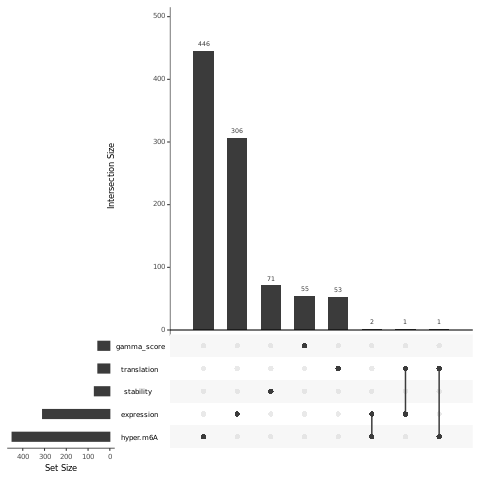

In [589]:
%%R -i Exp,Stbl,TE,Hyper_m6A,Rho,Gamma

Vecs <- list(
    gamma_score=unlist(Gamma), rho_score=unlist(Rho), 
    translation=unlist(TE), expression=unlist(Exp), 
    stability=unlist(Stbl), hyper.m6A=unlist(Hyper_m6A)
)
intersection <- Reduce(intersect,Vecs)
upset(fromList(Vecs), order.by = "freq")

# Final merged table

In [67]:
uniq_genes = list(
    set(TE.gene_name.tolist()) &
    set(Mtyl.gene_name.tolist()) &
    set(stbl_df.gene_name.tolist()) &
    set(exp_df.gene_name.tolist()) &
    set(Gamma.index.tolist()) &
    set(Rho.index.tolist())
)

In [73]:
len(uniq_genes)

662

I'm not sure which subset of genes are related to our purpose.

In [74]:
# %%R -i uniq_genes,TE
# # ,Mtyl,stbl_df,exp_df,Gamma,Rho
# t = TE %>% select(-'gene_id') %>% remove_rownames %>% column_to_rownames('gene_name')

# # unlist(uniq_genes)%>% head
# t %>% head



In [38]:
%%R 
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] UpSetR_1.4.0    forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2    
 [5] purrr_0.3.4     readr_1.4.0     tidyr_1.1.2     tibble_3.0.4   
 [9] ggplot2_3.3.2   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6     plyr_1.8.6       pillar_1.4.6     compiler_4.0.

In [40]:
# https://stackoverflow.com/questions/2617600/importing-data-from-a-json-file-into-r